In [3]:
import pandas as pd 

In [4]:
df = pd.read_csv('dataset.csv')

species_counts = df["species"].value_counts()
print(species_counts.head(3))

species
Caenorhabditis elegans     1559
Drosophila melanogaster     926
Mus musculus                277
Name: count, dtype: int64


Let's isolate our dataset to only rows that with the Canorhabiditis elegans species, since it has the most data points 

In [5]:
df = df[df["species"] == "Mus musculus"].reset_index(drop=True)
df.head(5) 

,id,compound_name,species,strain,dosage,age_at_initiation,treatment_duration,avg_lifespan_change_percent,avg_lifespan_significance,max_lifespan_change_percent,max_lifespan_significance,gender_new,weight_change_percent,weight_change_significance,ITP,pubmed_id,notes,last_modified
0,4111,Sodium thiosulfate,Mus musculus,UM-HET3,10000 ppm food,6 months,until death,-1.0,NS,0.0,NS,Male,-3.0,NS,Yes,38753230,NaN,2024-08-23 00:18:17
1,4110,Sodium thiosulfate,Mus musculus,UM-HET3,10000 ppm food,6 months,until death,5.0,NS,4.0,NS,Male,2.0,NS,Yes,38753230,NaN,2024-08-23 00:17:46
2,4109,16-alpha-hydroxyestradiol,Mus musculus,UM-HET3,5 ppm food,12 months,until death,-7.0,S,-5.0,NS,Female,-35.0,S,Yes,38753230,NaN,2024-08-23 00:11:34
3,4108,16-alpha-hydroxyestradiol,Mus musculus,UM-HET3,5 ppm food,12 months,until death,15.0,S,5.0,S,Male,-29.0,S,Yes,38753230,NaN,2024-08-23 00:11:01
4,4107,Nebivolol,Mus musculus,UM-HET3,60 ppm food,6 months,until death,-5.0,S,-5.0,NS,Female,-6.0,NS,Yes,38753230,NaN,2024-08-22 23:57:31


Now, lets define a few functions to convert the compounds to molecular fingerprints. We only have to do this for rows taht involve our specific species. 

In [6]:
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import ssl

# Disable SSL verification (only if you have certificate issues)
ssl._create_default_https_context = ssl._create_unverified_context


def get_smiles_from_pubchem(compound_name):
    """Fetch canonical SMILES for a compound name from PubChem."""
    try:
        compound = pcp.get_compounds(compound_name, 'name')
        if compound:
            return compound[0].canonical_smiles
    except Exception as e:
        print(f"Error fetching SMILES for {compound_name}: {e}")
    return None 

def smiles_to_ecfp(smiles, radius=2, n_bits=2048):
    """Generate ECFP (Morgan) fingerprint as a list of bits (0/1) from a SMILES string."""
    try:
        if smiles:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
                fp = generator.GetFingerprint(mol)
                return list(fp)
            else:
                print(f"Invalid SMILES: {smiles}")
        else:
            print("SMILES is None, skipping...")
    except Exception as e:
        print(f"Error generating ECFP for SMILES {smiles}: {e}")
    return None  

In [7]:
df.head() 

,id,compound_name,species,strain,dosage,age_at_initiation,treatment_duration,avg_lifespan_change_percent,avg_lifespan_significance,max_lifespan_change_percent,max_lifespan_significance,gender_new,weight_change_percent,weight_change_significance,ITP,pubmed_id,notes,last_modified
0,4111,Sodium thiosulfate,Mus musculus,UM-HET3,10000 ppm food,6 months,until death,-1.0,NS,0.0,NS,Male,-3.0,NS,Yes,38753230,NaN,2024-08-23 00:18:17
1,4110,Sodium thiosulfate,Mus musculus,UM-HET3,10000 ppm food,6 months,until death,5.0,NS,4.0,NS,Male,2.0,NS,Yes,38753230,NaN,2024-08-23 00:17:46
2,4109,16-alpha-hydroxyestradiol,Mus musculus,UM-HET3,5 ppm food,12 months,until death,-7.0,S,-5.0,NS,Female,-35.0,S,Yes,38753230,NaN,2024-08-23 00:11:34
3,4108,16-alpha-hydroxyestradiol,Mus musculus,UM-HET3,5 ppm food,12 months,until death,15.0,S,5.0,S,Male,-29.0,S,Yes,38753230,NaN,2024-08-23 00:11:01
4,4107,Nebivolol,Mus musculus,UM-HET3,60 ppm food,6 months,until death,-5.0,S,-5.0,NS,Female,-6.0,NS,Yes,38753230,NaN,2024-08-22 23:57:31


Now, we can convert all the compounds being tested on this most common species into molecular fingerprints. In addition, lets drop all rows in which either the ECFP is unavailable. Each of the bits can be a column, and hopefully this will make analyzing them by the machine a little bit easier  

In addition, we will aggregate the dosage and strain based on our new filtered dataset. Then, let's merge everything together to get a dataframe we can train on 


In [8]:
# First get unique compounds and their fingerprints
unique_compounds = df['compound_name'].unique()
compound_to_fingerprint = {}
valid_compounds = set()

print("Converting compounds to fingerprints...")
for compound in unique_compounds:
    smiles = get_smiles_from_pubchem(compound)
    if smiles:
        fingerprint = smiles_to_ecfp(smiles)
        if fingerprint:
            compound_to_fingerprint[compound] = fingerprint
            valid_compounds.add(compound)

# dropping rows where ECFP is unavailable
df_filtered = df[df['compound_name'].isin(valid_compounds)].drop_duplicates(subset=['compound_name']).reset_index(drop=True)

grouped_strain = df_filtered.groupby('strain').agg(
    avg_lifespan_change_percent = ('avg_lifespan_change_percent', 'mean'),
    avg_lifespan_change_percent_std = ('avg_lifespan_change_percent', 'std'),
    avg_lifespan_change_percent_sem = ('avg_lifespan_change_percent', 'sem'),
    avg_lifespan_change_percent_median = ('avg_lifespan_change_percent', 'median'),
    avg_lifespan_change_percent_min = ('avg_lifespan_change_percent', 'min'),
    avg_lifespan_change_percent_max = ('avg_lifespan_change_percent', 'max')
).reset_index()

grouped_dosage = df_filtered.groupby('dosage').agg(
    avg_lifespan_change_percent = ('avg_lifespan_change_percent', 'mean'),
    avg_lifespan_change_percent_std = ('avg_lifespan_change_percent', 'std'),
    avg_lifespan_change_percent_sem = ('avg_lifespan_change_percent', 'sem'),
    avg_lifespan_change_percent_median = ('avg_lifespan_change_percent', 'median'),
    avg_lifespan_change_percent_min = ('avg_lifespan_change_percent', 'min'),
    avg_lifespan_change_percent_max = ('avg_lifespan_change_percent', 'max')
).reset_index()

# 4. Add fingerprints as a single column array, replaces each of the compound names with their fingerprint
df_filtered['fingerprint'] = df_filtered['compound_name'].map(compound_to_fingerprint)

# 5. Merge everything together
final_df = df_filtered.merge(grouped_strain, on='strain', suffixes=('', '_strain'))
final_df = final_df.merge(grouped_dosage, on='dosage', suffixes=('', '_dosage'))

print("\nShape of final dataframe:", final_df.shape)
print("\nColumns in final dataframe:", final_df.columns.tolist())
final_df.head()

Converting compounds to fingerprints...

Shape of final dataframe: (70, 31)

Columns in final dataframe: ['id', 'compound_name', 'species', 'strain', 'dosage', 'age_at_initiation', 'treatment_duration', 'avg_lifespan_change_percent', 'avg_lifespan_significance', 'max_lifespan_change_percent', 'max_lifespan_significance', 'gender_new', 'weight_change_percent', 'weight_change_significance', 'ITP', 'pubmed_id', 'notes', 'last_modified', 'fingerprint', 'avg_lifespan_change_percent_strain', 'avg_lifespan_change_percent_std', 'avg_lifespan_change_percent_sem', 'avg_lifespan_change_percent_median', 'avg_lifespan_change_percent_min', 'avg_lifespan_change_percent_max', 'avg_lifespan_change_percent_dosage', 'avg_lifespan_change_percent_std_dosage', 'avg_lifespan_change_percent_sem_dosage', 'avg_lifespan_change_percent_median_dosage', 'avg_lifespan_change_percent_min_dosage', 'avg_lifespan_change_percent_max_dosage']


,id,compound_name,species,strain,dosage,age_at_initiation,treatment_duration,avg_lifespan_change_percent,avg_lifespan_significance,max_lifespan_change_percent,...,avg_lifespan_change_percent_sem,avg_lifespan_change_percent_median,avg_lifespan_change_percent_min,avg_lifespan_change_percent_max,avg_lifespan_change_percent_dosage,avg_lifespan_change_percent_std_dosage,avg_lifespan_change_percent_sem_dosage,avg_lifespan_change_percent_median_dosage,avg_lifespan_change_percent_min_dosage,avg_lifespan_change_percent_max_dosage
0,4111,Sodium thiosulfate,Mus musculus,UM-HET3,10000 ppm food,6 months,until death,-1.0,NS,0.0,...,0.461463,0.0,-7.0,5.0,-3.250000,9.322911,4.661455,-5.5,-11.0,9.0
1,4109,16-alpha-hydroxyestradiol,Mus musculus,UM-HET3,5 ppm food,12 months,until death,-7.0,S,-5.0,...,0.461463,0.0,-7.0,5.0,-4.500000,3.535534,2.500000,-4.5,-7.0,-2.0
2,4107,Nebivolol,Mus musculus,UM-HET3,60 ppm food,6 months,until death,-5.0,S,-5.0,...,0.461463,0.0,-7.0,5.0,-5.000000,NaN,NaN,-5.0,-5.0,-5.0
3,4105,Hydralazine,Mus musculus,UM-HET3,30 ppm food,16 months,until death,-2.0,NS,1.0,...,0.461463,0.0,-7.0,5.0,-1.666667,2.516611,1.452966,-2.0,-4.0,1.0
4,4101,"2,4-dinitrophenol",Mus musculus,UM-HET3,3 ppm food,6 months,until death,-4.0,NS,0.0,...,0.461463,0.0,-7.0,5.0,-4.000000,NaN,NaN,-4.0,-4.0,-4.0


To ensure we train our model on a complete dataset, let's drop rows in which the average life span affect is unavailable

In [9]:
# Drop rows with missing target values
final_df = final_df.dropna(subset=['avg_lifespan_change_percent'])


We now seperate out inputs (ECFP) and outputs (affect on lifespan) 

In [10]:
import numpy as np

# Convert fingerprint lists into NumPy array for ML compatibility
X = np.array(final_df['fingerprint'].tolist())

# Use lifespan change as the target variable
y = final_df['avg_lifespan_change_percent'].values

print(f"Feature shape (X): {X.shape}")  
print(f"Target shape (y): {y.shape}") 

Feature shape (X): (68, 2048)
Target shape (y): (68,)


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Perform 5-fold cross-validation
model = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring='r2')


In [12]:
duplicate_count = final_df["compound_name"].duplicated().sum()
print(f"Number of duplicate compounds: {duplicate_count}")


Number of duplicate compounds: 0


Splitting that dataset into 80% training, 20% testing

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

# Train the final model on the full training set
model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Test Set R² Score: {r2:.3f}")

Training set size: (54, 2048), Test set size: (14, 2048)
Test Set R² Score: 0.284


Testing our model with the RandomForestRegressor model 

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with 100 trees
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

print("Random Forest training completed.")


Random Forest training completed.


To measure the accuracy of our model, we use a seaborn plot. 

In [15]:
import sys
print(sys.executable)

/opt/homebrew/anaconda3/bin/python


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Seaborn and Matplotlib imported successfully!")

Seaborn and Matplotlib imported successfully!


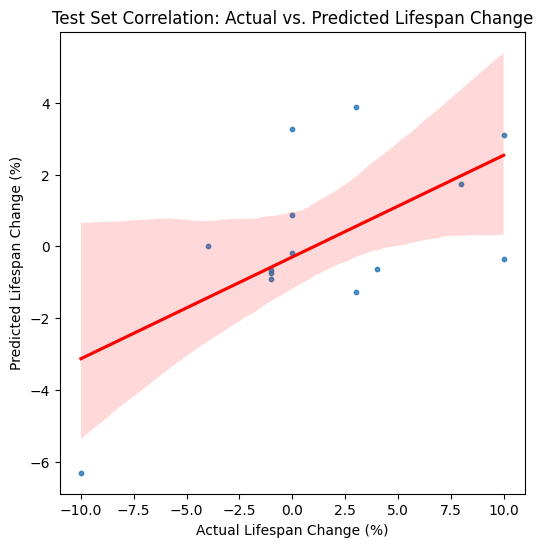

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot of actual vs predicted values
plt.figure(figsize=(6, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel("Actual Lifespan Change (%)")
plt.ylabel("Predicted Lifespan Change (%)")
plt.title("Test Set Correlation: Actual vs. Predicted Lifespan Change")
plt.show()

In [18]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.3f}")

R² Score: 0.284
